In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split, KFold
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import F1Score
import warnings
import optuna
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
from utils import *

# Import data

In [3]:
FOLDS = 5 # number of folds for CV (== number of fusions tried)
SEED = 2022

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# import data
data = import_data()

In [6]:
%%time
# preprocessing (tokenization, discard long sentence, lowercase etc.)
data = preproc(data)

Tokenizing the data...
Length of the data :  29544
CPU times: total: 4min 3s
Wall time: 4min 8s


In [7]:
%%time
# data split (CV)
datasets = []
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for i, (train_indices, test_indices) in enumerate(cv.split(data)):
    train_set, test_set = data.loc[train_indices, :], data.loc[test_indices, :]

    datasets.append((train_set, test_set))

CPU times: total: 31.2 ms
Wall time: 32.5 ms


# CV

### Definition

In [8]:
LEARNING_RATE = 2e-4 # starting learning rate for scheduler
EPOCHS = 'unrestricted' # use 'unrestricted' for full convergence
N_HEADS = 4

In [9]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, embedding, pad_idx, voc_size, device, lr=2e-4, save=True):
    # init
    model = new_model(embedding, pad_idx, voc_size, device, n_head=N_HEADS) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch=EPOCHS,
                    clip=1,
                    device=device)

    if save:
        # save model
        name = f'parallel_training/model{model_name}_IMDB_256'
        save_model(model, name=name)

        # save history
        name = f'parallel_training/history_model{model_name}_IMDB_256'
        save_history(history, name=name)

    return model

### Evaluation

In [10]:
model_names = ['A', 'B', 'vanilla_pre', 'vanilla_post', 'OT_pre (method 1)', 'OT_post (method 1)', 'OT_pre (method 2)', 'OT_post (method 2)', 'OT_pre (method 3)', 'OT_post (method 3)', 'random']
scores = {'loss': {model_name: [] for model_name in model_names},
          'accuracy': {model_name: [] for model_name in model_names},
          'f1': {model_name: [] for model_name in model_names},}

Fold 1/5
Vocabulary Size :  23044


100%|██████████| 5908/5908 [00:00<00:00, 17662.47it/s]


Positive labels ratio (train set): 0.5019461837874429
Positive labels ratio (test set): 0.506093432633717
Dataset initializing done
Starting training for model A


Epoch: 90 - Train Loss: 0.1875 / Validation Loss: 0.4790 / Train acc: 0.9300 / Val acc: 0.8134 / Learning Rate : 0.0000:   0%|          | 90/1000000 [07:33<1392:52:34,  5.01s/it]

Training has converged after 90 epochs (lr < 1e-06)


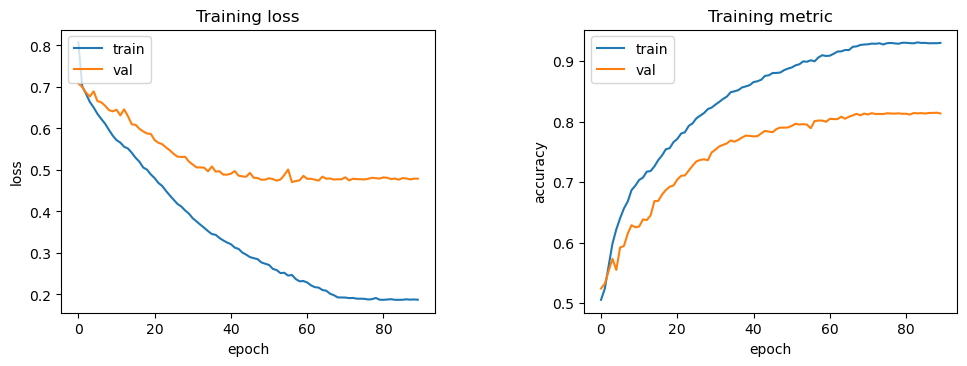

Epoch: 90 - Train Loss: 0.1875 / Validation Loss: 0.4790 / Train acc: 0.9300 / Val acc: 0.8134 / Learning Rate : 0.0000:   0%|          | 90/1000000 [07:34<1401:17:37,  5.05s/it]


Starting training for model B


Epoch: 49 - Train Loss: 0.1589 / Validation Loss: 0.3945 / Train acc: 0.9449 / Val acc: 0.8488 / Learning Rate : 0.0000:   0%|          | 49/1000000 [04:09<1367:15:31,  4.92s/it]

Training has converged after 49 epochs (lr < 1e-06)


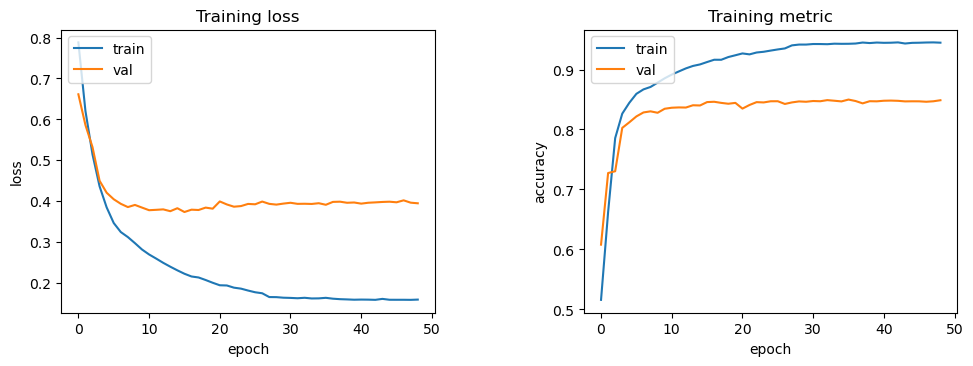

Epoch: 49 - Train Loss: 0.1589 / Validation Loss: 0.3945 / Train acc: 0.9449 / Val acc: 0.8488 / Learning Rate : 0.0000:   0%|          | 49/1000000 [04:09<1413:49:41,  5.09s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.17577364838090986
fusion successful
fusion succes

Epoch: 134 - Train Loss: 0.1803 / Validation Loss: 0.4282 / Train acc: 0.9394 / Val acc: 0.8198 / Learning Rate : 0.0000:   0%|          | 134/1000000 [04:51<612:30:54,  2.21s/it]

Training has converged after 134 epochs (lr < 1e-06)


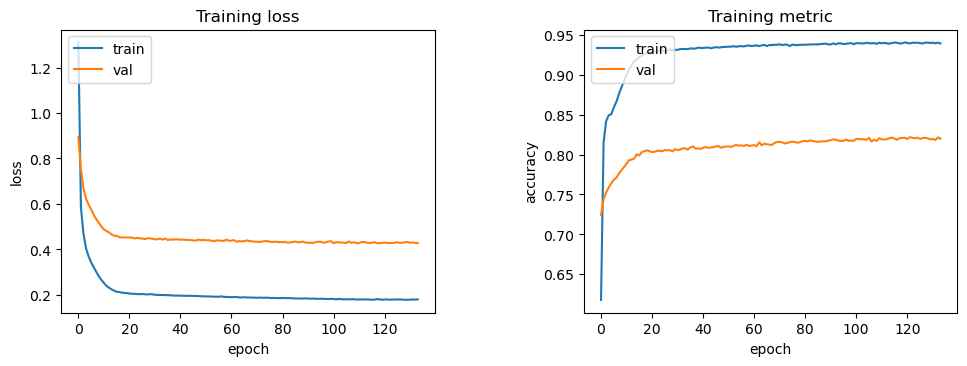

Epoch: 134 - Train Loss: 0.1803 / Validation Loss: 0.4282 / Train acc: 0.9394 / Val acc: 0.8198 / Learning Rate : 0.0000:   0%|          | 134/1000000 [04:51<604:51:58,  2.18s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 139 - Train Loss: 0.1978 / Validation Loss: 0.4276 / Train acc: 0.9355 / Val acc: 0.8153 / Learning Rate : 0.0000:   0%|          | 139/1000000 [11:02<1296:11:33,  4.67s/it]

Training has converged after 139 epochs (lr < 1e-06)


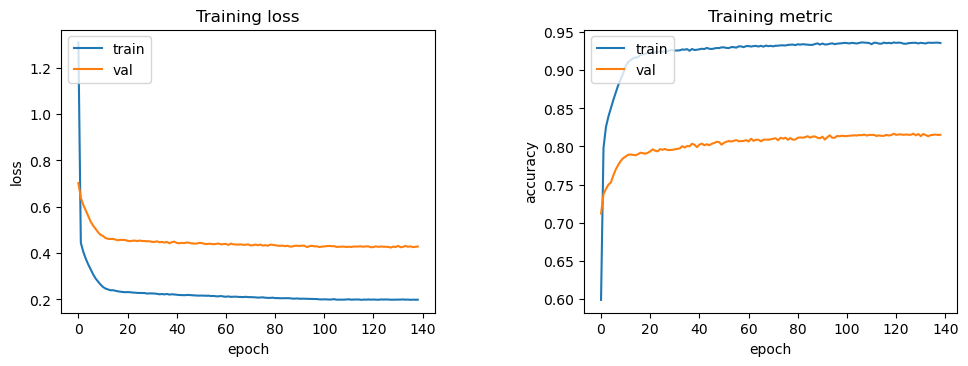

Epoch: 139 - Train Loss: 0.1978 / Validation Loss: 0.4276 / Train acc: 0.9355 / Val acc: 0.8153 / Learning Rate : 0.0000:   0%|          | 139/1000000 [11:02<1324:31:35,  4.77s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 199 - Train Loss: 0.1831 / Validation Loss: 0.4459 / Train acc: 0.9340 / Val acc: 0.8159 / Learning Rate : 0.0000:   0%|          | 199/1000000 [15:24<1287:12:19,  4.63s/it]

Training has converged after 199 epochs (lr < 1e-06)


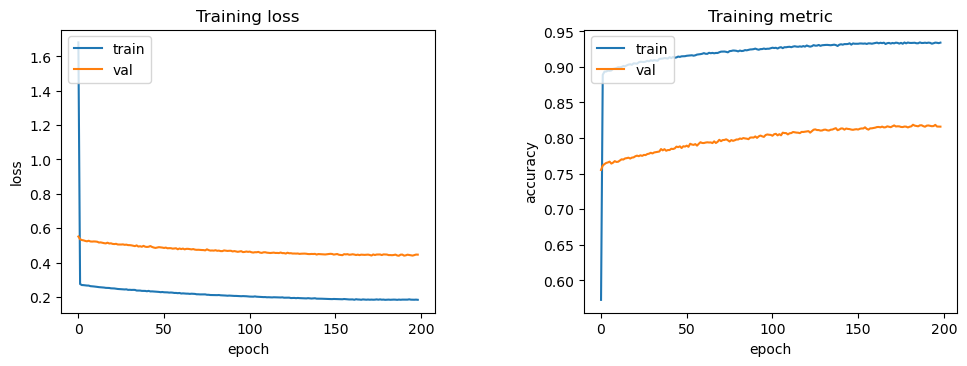

Epoch: 199 - Train Loss: 0.1831 / Validation Loss: 0.4459 / Train acc: 0.9340 / Val acc: 0.8159 / Learning Rate : 0.0000:   0%|          | 199/1000000 [15:24<1290:26:40,  4.65s/it]


Starting retraining for model OT fusion (method 3)


Epoch: 219 - Train Loss: 0.1840 / Validation Loss: 0.4446 / Train acc: 0.9351 / Val acc: 0.8145 / Learning Rate : 0.0000:   0%|          | 219/1000000 [16:54<1286:04:45,  4.63s/it]

Training has converged after 219 epochs (lr < 1e-06)


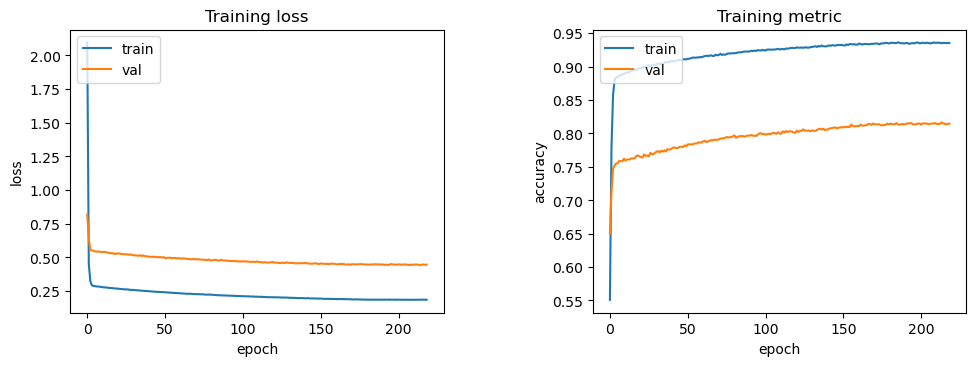

Epoch: 219 - Train Loss: 0.1840 / Validation Loss: 0.4446 / Train acc: 0.9351 / Val acc: 0.8145 / Learning Rate : 0.0000:   0%|          | 219/1000000 [16:54<1286:55:26,  4.63s/it]


OT_post (method 1) loss: 0.4303509220480919 - accuracy: 0.8119102883454106 - f1: 0.8107650876045227
OT_post (method 2) loss: 0.44369592765967053 - accuracy: 0.8167482827596617 - f1: 0.8165199756622314
OT_post (method 3) loss: 0.4444693401455879 - accuracy: 0.8138209541062802 - f1: 0.8144888281822205
vanilla_post loss: 0.45369026561578113 - accuracy: 0.8069590692934782 - f1: 0.8061949610710144
Fold 2/5
Vocabulary Size :  23054


100%|██████████| 5909/5909 [00:00<00:00, 19963.27it/s]


Positive labels ratio (train set): 0.5059022635921303
Positive labels ratio (test set): 0.4902690810627856
Dataset initializing done
Starting training for model A


Epoch: 91 - Train Loss: 0.1771 / Validation Loss: 0.4880 / Train acc: 0.9359 / Val acc: 0.8106 / Learning Rate : 0.0000:   0%|          | 91/1000000 [07:14<1330:31:07,  4.79s/it]

Training has converged after 91 epochs (lr < 1e-06)


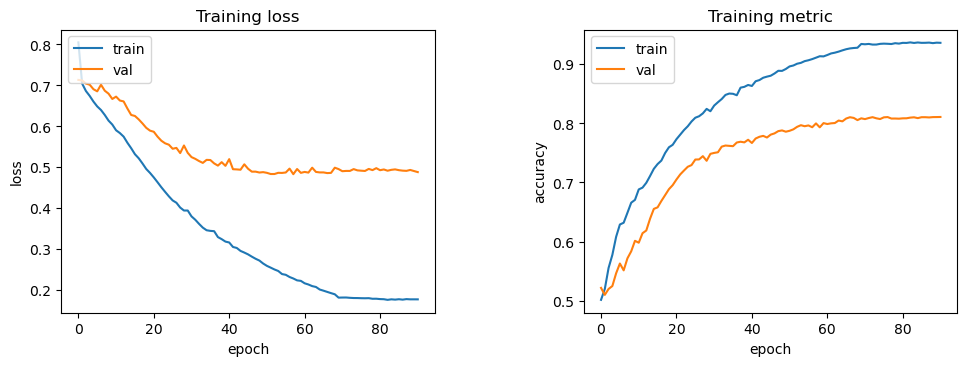

Epoch: 91 - Train Loss: 0.1771 / Validation Loss: 0.4880 / Train acc: 0.9359 / Val acc: 0.8106 / Learning Rate : 0.0000:   0%|          | 91/1000000 [07:14<1326:08:17,  4.77s/it]


Starting training for model B


Epoch: 48 - Train Loss: 0.1732 / Validation Loss: 0.4132 / Train acc: 0.9372 / Val acc: 0.8349 / Learning Rate : 0.0000:   0%|          | 48/1000000 [03:53<1325:34:53,  4.77s/it]

Training has converged after 48 epochs (lr < 1e-06)


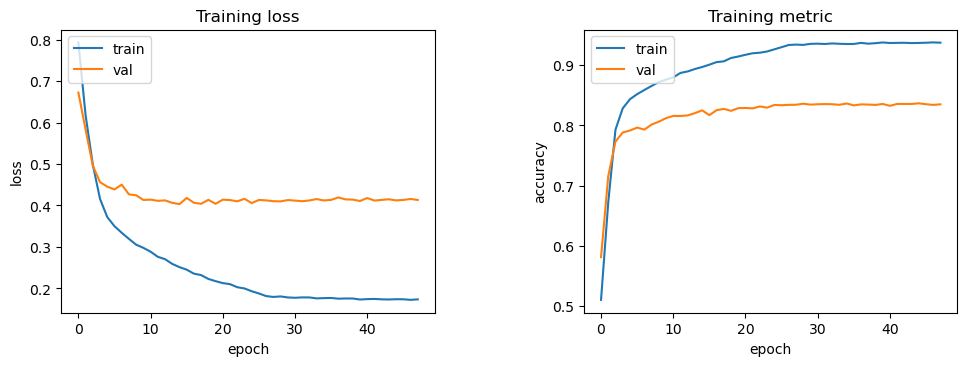

Epoch: 48 - Train Loss: 0.1732 / Validation Loss: 0.4132 / Train acc: 0.9372 / Val acc: 0.8349 / Learning Rate : 0.0000:   0%|          | 48/1000000 [03:53<1353:33:35,  4.87s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.3957327751054346
fusion successful
fusion success

Epoch: 128 - Train Loss: 0.2154 / Validation Loss: 0.4688 / Train acc: 0.9242 / Val acc: 0.7964 / Learning Rate : 0.0000:   0%|          | 128/1000000 [04:36<598:48:12,  2.16s/it]

Training has converged after 128 epochs (lr < 1e-06)


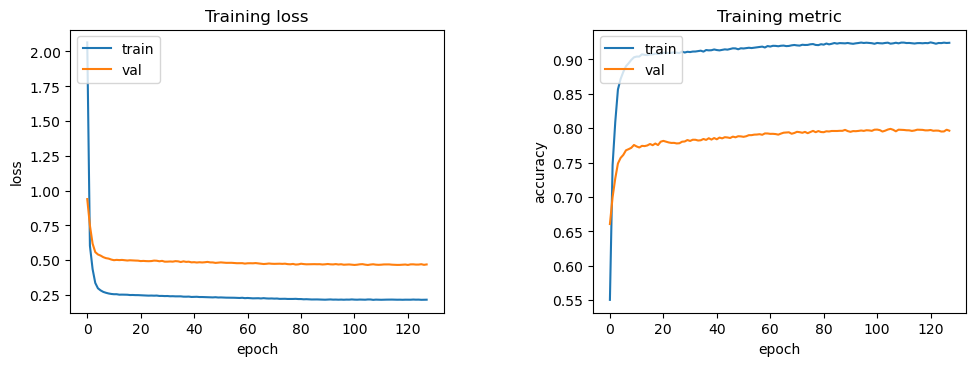

Epoch: 128 - Train Loss: 0.2154 / Validation Loss: 0.4688 / Train acc: 0.9242 / Val acc: 0.7964 / Learning Rate : 0.0000:   0%|          | 128/1000000 [04:37<601:08:41,  2.16s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 136 - Train Loss: 0.1936 / Validation Loss: 0.4419 / Train acc: 0.9343 / Val acc: 0.8116 / Learning Rate : 0.0000:   0%|          | 136/1000000 [10:26<1270:15:27,  4.57s/it]

Training has converged after 136 epochs (lr < 1e-06)


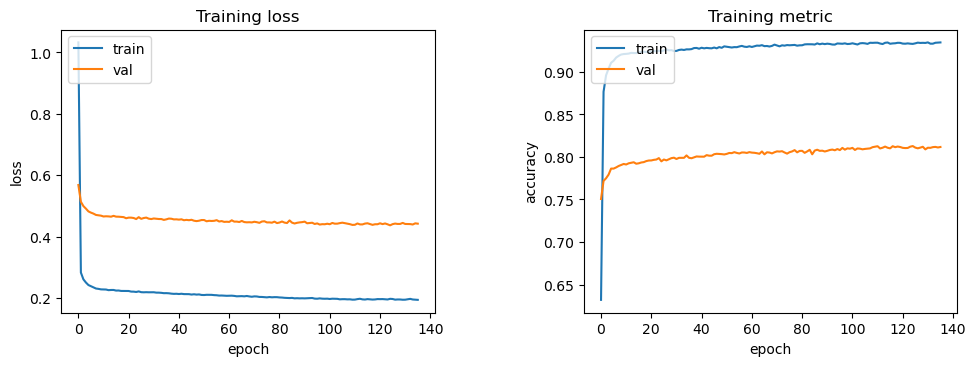

Epoch: 136 - Train Loss: 0.1936 / Validation Loss: 0.4419 / Train acc: 0.9343 / Val acc: 0.8116 / Learning Rate : 0.0000:   0%|          | 136/1000000 [10:27<1280:47:17,  4.61s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 182 - Train Loss: 0.2115 / Validation Loss: 0.4642 / Train acc: 0.9267 / Val acc: 0.7988 / Learning Rate : 0.0000:   0%|          | 182/1000000 [13:55<1273:37:52,  4.59s/it]

Training has converged after 182 epochs (lr < 1e-06)


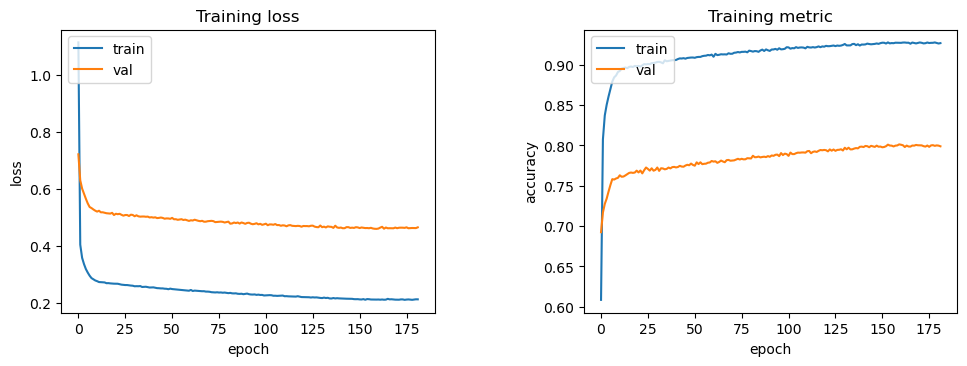

Epoch: 182 - Train Loss: 0.2115 / Validation Loss: 0.4642 / Train acc: 0.9267 / Val acc: 0.7988 / Learning Rate : 0.0000:   0%|          | 182/1000000 [13:55<1274:34:41,  4.59s/it]


Starting retraining for model OT fusion (method 3)


Epoch: 136 - Train Loss: 0.2056 / Validation Loss: 0.4603 / Train acc: 0.9285 / Val acc: 0.8043 / Learning Rate : 0.0000:   0%|          | 136/1000000 [10:08<1235:44:26,  4.45s/it]

Training has converged after 136 epochs (lr < 1e-06)


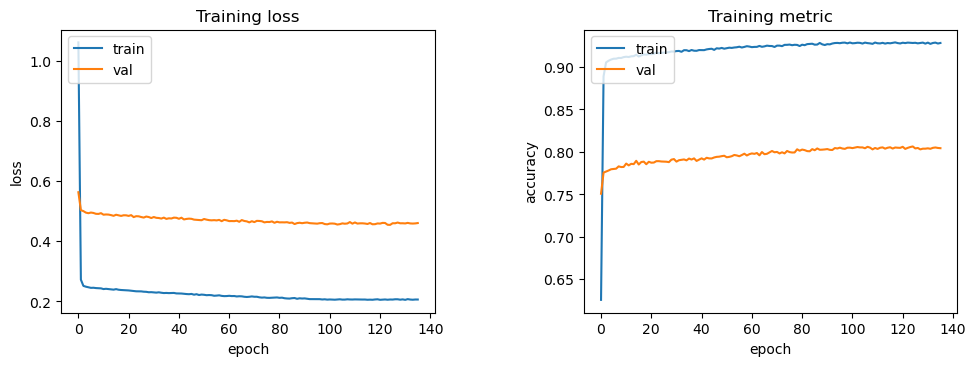

Epoch: 136 - Train Loss: 0.2056 / Validation Loss: 0.4603 / Train acc: 0.9285 / Val acc: 0.8043 / Learning Rate : 0.0000:   0%|          | 136/1000000 [10:09<1243:49:18,  4.48s/it]


OT_post (method 1) loss: 0.4567270800471306 - accuracy: 0.8056846278956076 - f1: 0.8047047257423401
OT_post (method 2) loss: 0.4661713515718778 - accuracy: 0.7975665848751504 - f1: 0.7982738018035889
OT_post (method 3) loss: 0.45597557971874875 - accuracy: 0.8055712244283995 - f1: 0.8048739433288574
vanilla_post loss: 0.4961387316385905 - accuracy: 0.7880030883348376 - f1: 0.7876121401786804
Fold 3/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 21256.01it/s]


Positive labels ratio (train set): 0.5016289401311614
Positive labels ratio (test set): 0.5073616517177187
Dataset initializing done
Starting training for model A


Epoch: 86 - Train Loss: 0.1933 / Validation Loss: 0.5217 / Train acc: 0.9276 / Val acc: 0.8010 / Learning Rate : 0.0000:   0%|          | 86/1000000 [06:31<1267:19:29,  4.56s/it]

Training has converged after 86 epochs (lr < 1e-06)


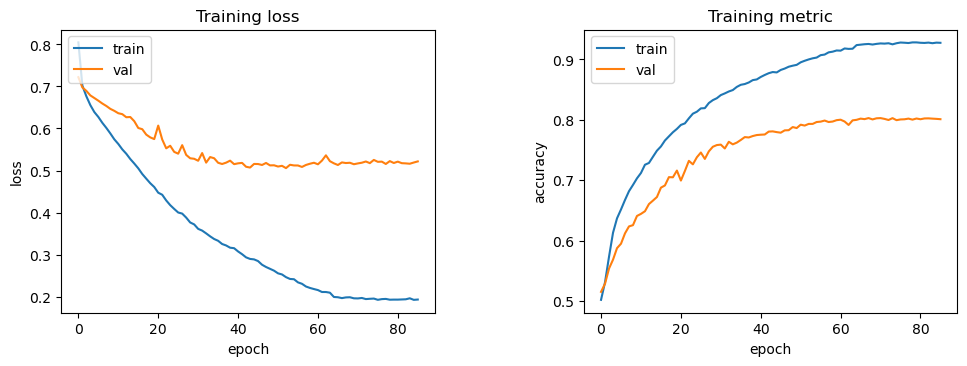

Epoch: 86 - Train Loss: 0.1933 / Validation Loss: 0.5217 / Train acc: 0.9276 / Val acc: 0.8010 / Learning Rate : 0.0000:   0%|          | 86/1000000 [06:31<1265:42:30,  4.56s/it]


Starting training for model B


Epoch: 42 - Train Loss: 0.1984 / Validation Loss: 0.4453 / Train acc: 0.9257 / Val acc: 0.8215 / Learning Rate : 0.0000:   0%|          | 42/1000000 [03:11<1268:27:48,  4.57s/it]

Training has converged after 42 epochs (lr < 1e-06)


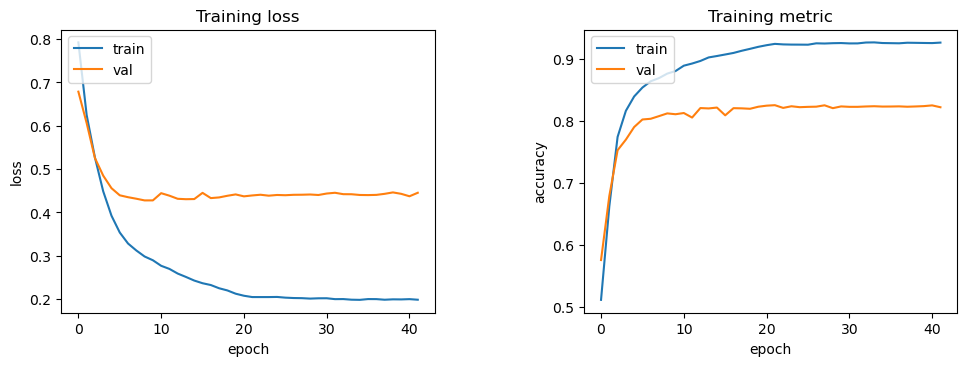

Epoch: 42 - Train Loss: 0.1984 / Validation Loss: 0.4453 / Train acc: 0.9257 / Val acc: 0.8215 / Learning Rate : 0.0000:   0%|          | 42/1000000 [03:11<1267:00:33,  4.56s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.9988427486460114
fusion successful
fusion success

Epoch: 99 - Train Loss: 0.2239 / Validation Loss: 0.4776 / Train acc: 0.9230 / Val acc: 0.7881 / Learning Rate : 0.0000:   0%|          | 99/1000000 [03:22<566:18:31,  2.04s/it]

Training has converged after 99 epochs (lr < 1e-06)


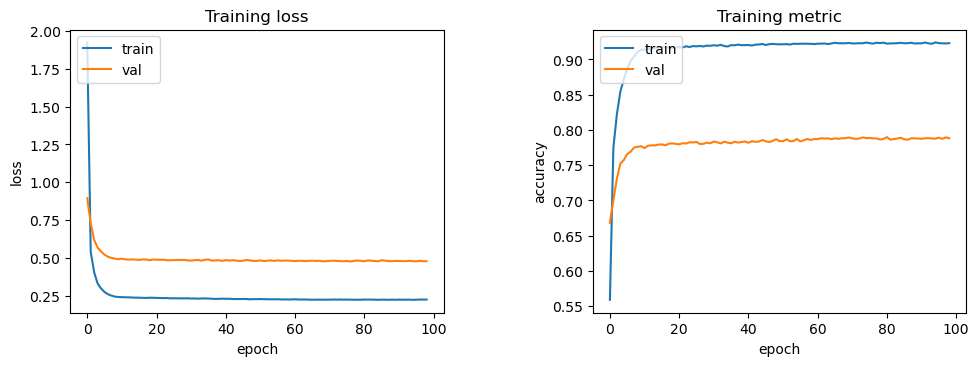

Epoch: 99 - Train Loss: 0.2239 / Validation Loss: 0.4776 / Train acc: 0.9230 / Val acc: 0.7881 / Learning Rate : 0.0000:   0%|          | 99/1000000 [03:22<568:52:12,  2.05s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 109 - Train Loss: 0.2351 / Validation Loss: 0.5155 / Train acc: 0.9091 / Val acc: 0.7754 / Learning Rate : 0.0000:   0%|          | 109/1000000 [08:06<1236:01:06,  4.45s/it]

Training has converged after 109 epochs (lr < 1e-06)


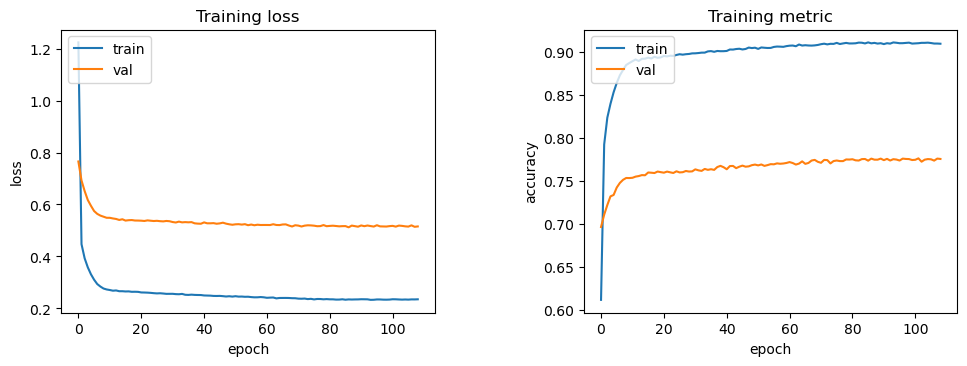

Epoch: 109 - Train Loss: 0.2351 / Validation Loss: 0.5155 / Train acc: 0.9091 / Val acc: 0.7754 / Learning Rate : 0.0000:   0%|          | 109/1000000 [08:06<1239:12:13,  4.46s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 170 - Train Loss: 0.2247 / Validation Loss: 0.4972 / Train acc: 0.9162 / Val acc: 0.7838 / Learning Rate : 0.0000:   0%|          | 170/1000000 [12:38<1241:33:14,  4.47s/it]

Training has converged after 170 epochs (lr < 1e-06)


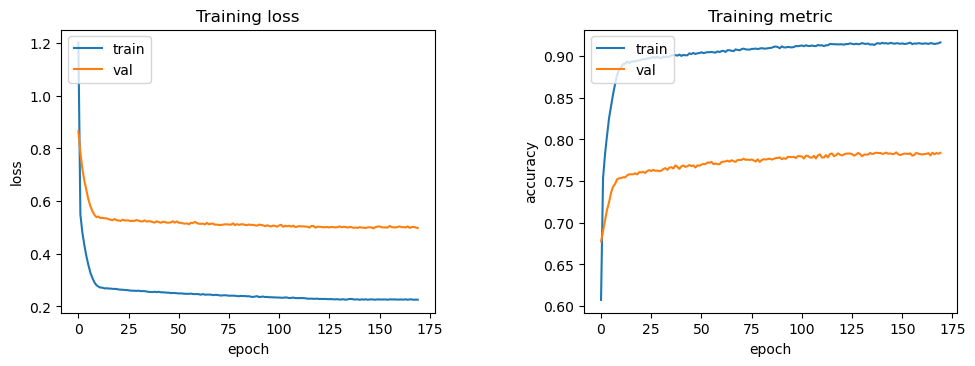

Epoch: 170 - Train Loss: 0.2247 / Validation Loss: 0.4972 / Train acc: 0.9162 / Val acc: 0.7838 / Learning Rate : 0.0000:   0%|          | 170/1000000 [12:38<1239:11:41,  4.46s/it]


Starting retraining for model OT fusion (method 3)


Epoch: 136 - Train Loss: 0.2419 / Validation Loss: 0.5224 / Train acc: 0.9056 / Val acc: 0.7685 / Learning Rate : 0.0000:   0%|          | 136/1000000 [10:06<1235:40:56,  4.45s/it]

Training has converged after 136 epochs (lr < 1e-06)


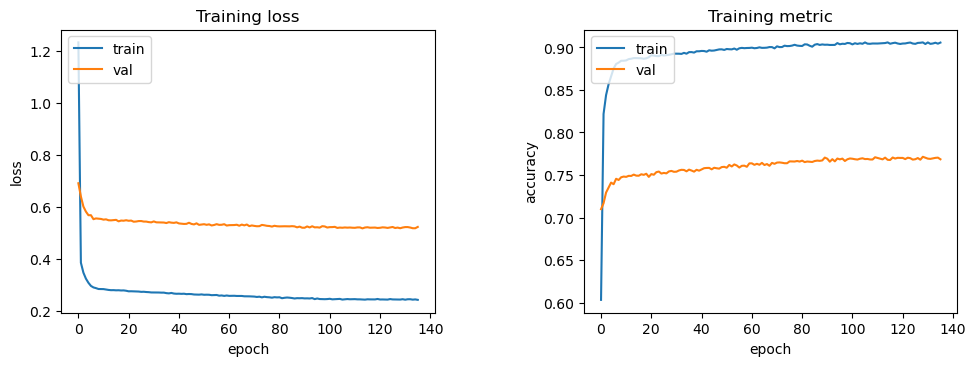

Epoch: 136 - Train Loss: 0.2419 / Validation Loss: 0.5224 / Train acc: 0.9056 / Val acc: 0.7685 / Learning Rate : 0.0000:   0%|          | 136/1000000 [10:06<1238:46:50,  4.46s/it]


OT_post (method 1) loss: 0.5139015838503838 - accuracy: 0.7756826536176293 - f1: 0.7750888466835022
OT_post (method 2) loss: 0.4981713394323985 - accuracy: 0.7833717612439832 - f1: 0.7823657989501953
OT_post (method 3) loss: 0.5205944279829661 - accuracy: 0.7680775703219013 - f1: 0.7693349123001099
vanilla_post loss: 0.47918861111005145 - accuracy: 0.7883532876429001 - f1: 0.7881197929382324
Fold 4/5
Vocabulary Size :  23075


100%|██████████| 5909/5909 [00:00<00:00, 22340.98it/s]


Positive labels ratio (train set): 0.5009519779987307
Positive labels ratio (test set): 0.5100693856828566
Dataset initializing done
Starting training for model A


Epoch: 99 - Train Loss: 0.1730 / Validation Loss: 0.5253 / Train acc: 0.9372 / Val acc: 0.8035 / Learning Rate : 0.0000:   0%|          | 99/1000000 [07:30<1266:13:04,  4.56s/it]

Training has converged after 99 epochs (lr < 1e-06)


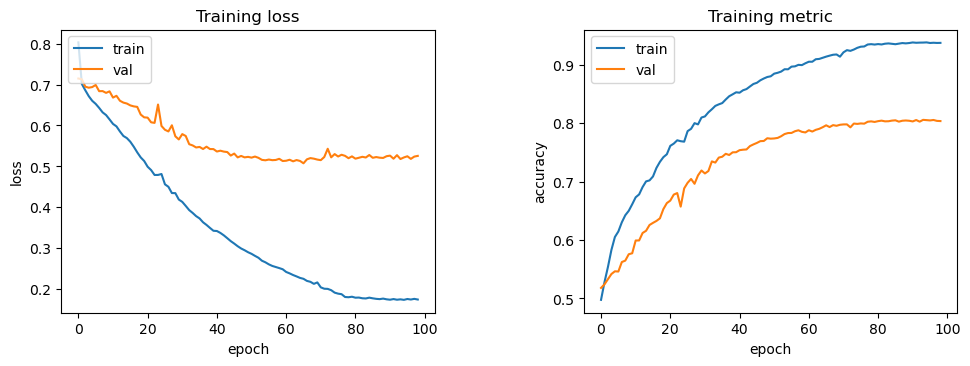

Epoch: 99 - Train Loss: 0.1730 / Validation Loss: 0.5253 / Train acc: 0.9372 / Val acc: 0.8035 / Learning Rate : 0.0000:   0%|          | 99/1000000 [07:31<1265:49:37,  4.56s/it]


Starting training for model B


Epoch: 43 - Train Loss: 0.1730 / Validation Loss: 0.4201 / Train acc: 0.9366 / Val acc: 0.8341 / Learning Rate : 0.0000:   0%|          | 43/1000000 [03:15<1264:12:20,  4.55s/it]

Training has converged after 43 epochs (lr < 1e-06)


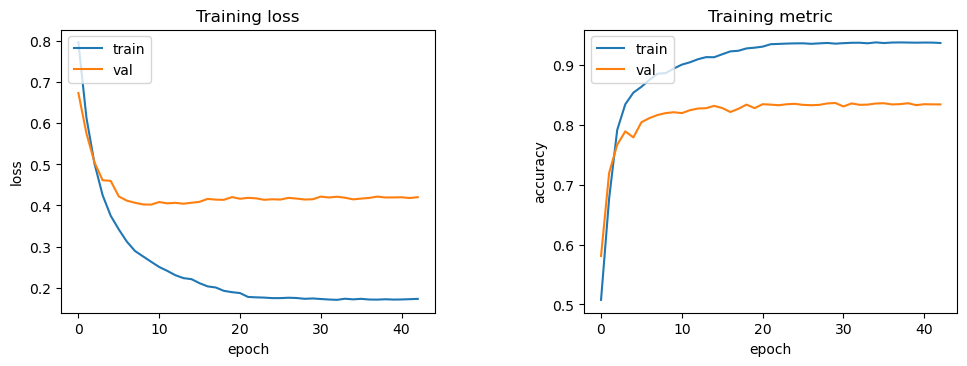

Epoch: 43 - Train Loss: 0.1730 / Validation Loss: 0.4201 / Train acc: 0.9366 / Val acc: 0.8341 / Learning Rate : 0.0000:   0%|          | 43/1000000 [03:16<1267:01:23,  4.56s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.9996654961803845
fusion successful
fusion success

Epoch: 100 - Train Loss: 0.1989 / Validation Loss: 0.4646 / Train acc: 0.9297 / Val acc: 0.7963 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:24<567:19:57,  2.04s/it]

Training has converged after 100 epochs (lr < 1e-06)


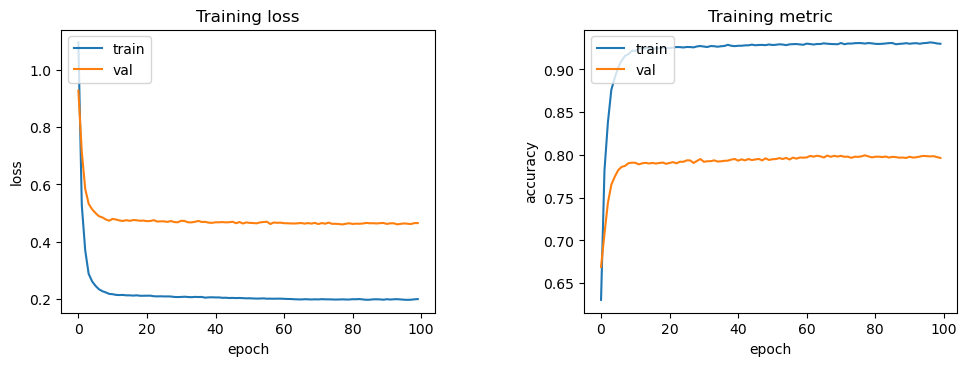

Epoch: 100 - Train Loss: 0.1989 / Validation Loss: 0.4646 / Train acc: 0.9297 / Val acc: 0.7963 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:25<569:44:28,  2.05s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 196 - Train Loss: 0.1924 / Validation Loss: 0.5014 / Train acc: 0.9297 / Val acc: 0.7882 / Learning Rate : 0.0000:   0%|          | 196/1000000 [14:34<1245:17:48,  4.48s/it]

Training has converged after 196 epochs (lr < 1e-06)


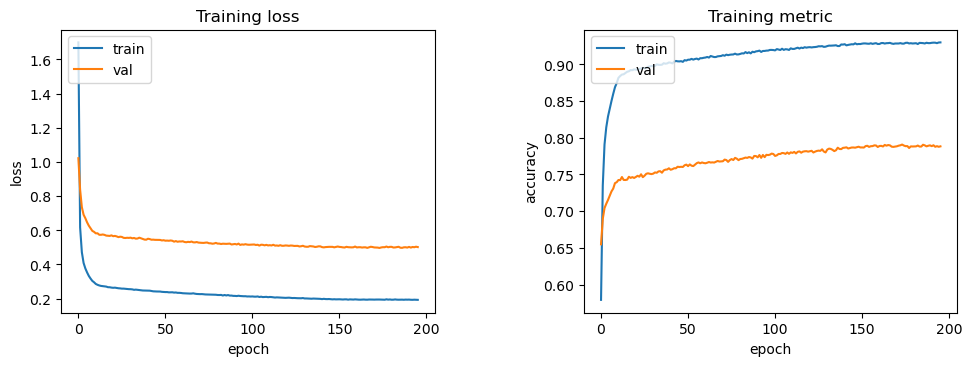

Epoch: 196 - Train Loss: 0.1924 / Validation Loss: 0.5014 / Train acc: 0.9297 / Val acc: 0.7882 / Learning Rate : 0.0000:   0%|          | 196/1000000 [14:34<1239:22:43,  4.46s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 136 - Train Loss: 0.2029 / Validation Loss: 0.4459 / Train acc: 0.9314 / Val acc: 0.8058 / Learning Rate : 0.0000:   0%|          | 136/1000000 [10:07<1234:06:35,  4.44s/it]

Training has converged after 136 epochs (lr < 1e-06)


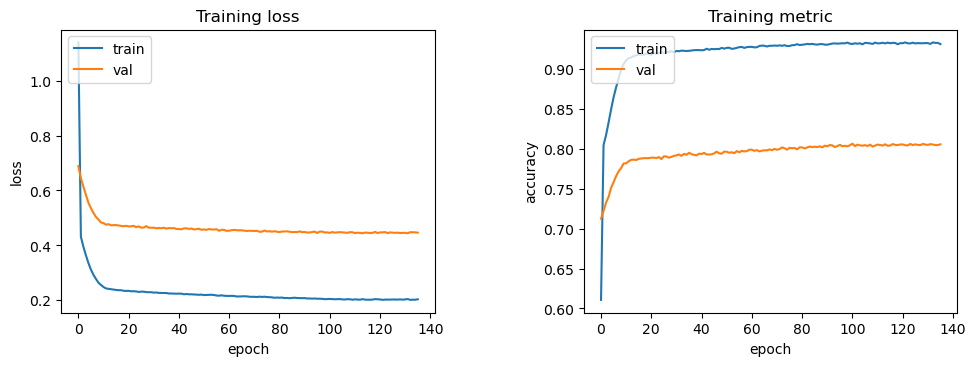

Epoch: 136 - Train Loss: 0.2029 / Validation Loss: 0.4459 / Train acc: 0.9314 / Val acc: 0.8058 / Learning Rate : 0.0000:   0%|          | 136/1000000 [10:07<1240:04:34,  4.46s/it]


Starting retraining for model OT fusion (method 3)


Epoch: 82 - Train Loss: 0.2240 / Validation Loss: 0.4835 / Train acc: 0.9207 / Val acc: 0.7820 / Learning Rate : 0.0000:   0%|          | 82/1000000 [06:05<1233:39:35,  4.44s/it]

Training has converged after 82 epochs (lr < 1e-06)


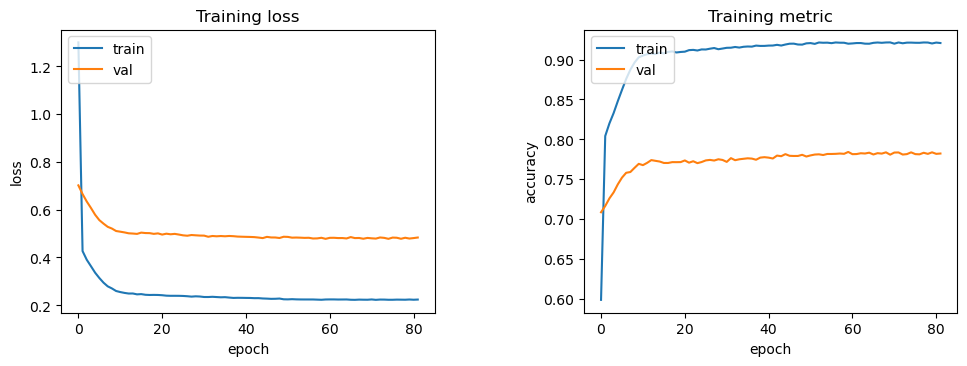

Epoch: 82 - Train Loss: 0.2240 / Validation Loss: 0.4835 / Train acc: 0.9207 / Val acc: 0.7820 / Learning Rate : 0.0000:   0%|          | 82/1000000 [06:05<1237:48:44,  4.46s/it]


OT_post (method 1) loss: 0.5024639566739401 - accuracy: 0.7856504070773165 - f1: 0.7847351431846619
OT_post (method 2) loss: 0.44934923698504764 - accuracy: 0.803287877933213 - f1: 0.8043662309646606
OT_post (method 3) loss: 0.480438898007075 - accuracy: 0.7820156202993381 - f1: 0.7825351357460022
vanilla_post loss: 0.47002141177654266 - accuracy: 0.7927824862740673 - f1: 0.7938737273216248
Fold 5/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 21104.09it/s]


Positive labels ratio (train set): 0.503448275862069
Positive labels ratio (test set): 0.5000846166864106
Dataset initializing done
Starting training for model A


Epoch: 94 - Train Loss: 0.2035 / Validation Loss: 0.4823 / Train acc: 0.9232 / Val acc: 0.8073 / Learning Rate : 0.0000:   0%|          | 94/1000000 [07:07<1266:27:57,  4.56s/it]

Training has converged after 94 epochs (lr < 1e-06)


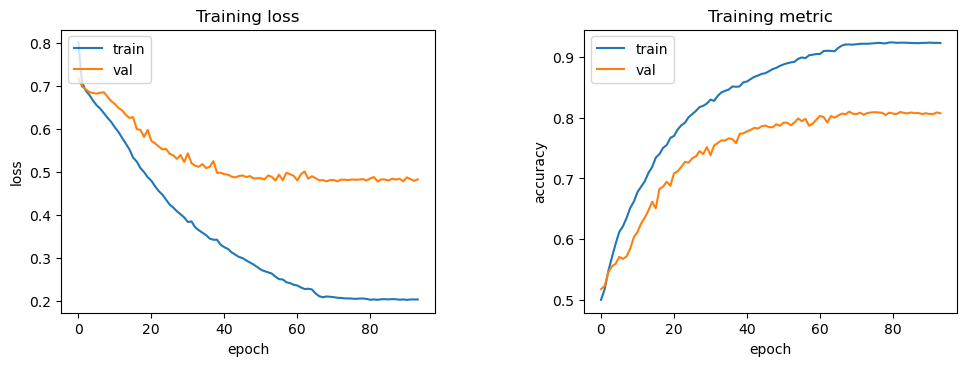

Epoch: 94 - Train Loss: 0.2035 / Validation Loss: 0.4823 / Train acc: 0.9232 / Val acc: 0.8073 / Learning Rate : 0.0000:   0%|          | 94/1000000 [07:07<1264:15:43,  4.55s/it]


Starting training for model B


Epoch: 55 - Train Loss: 0.1469 / Validation Loss: 0.4185 / Train acc: 0.9484 / Val acc: 0.8387 / Learning Rate : 0.0000:   0%|          | 55/1000000 [04:10<1262:37:01,  4.55s/it]

Training has converged after 55 epochs (lr < 1e-06)


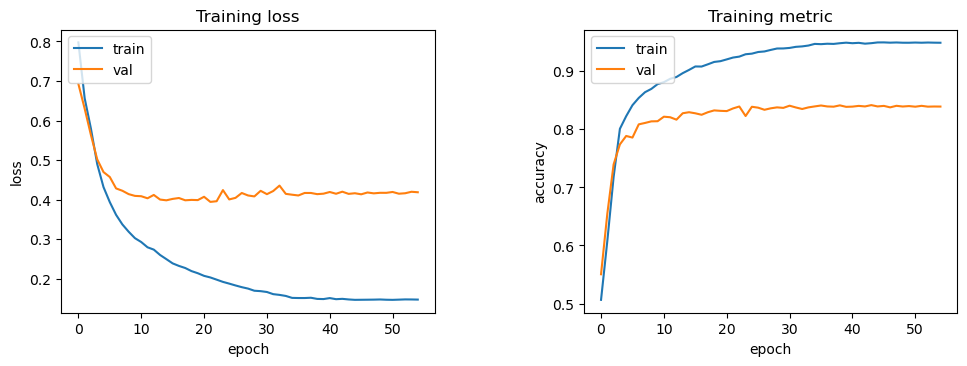

Epoch: 55 - Train Loss: 0.1469 / Validation Loss: 0.4185 / Train acc: 0.9484 / Val acc: 0.8387 / Learning Rate : 0.0000:   0%|          | 55/1000000 [04:10<1264:31:45,  4.55s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.0006212671912167525
fusion successful
fusion succ

Epoch: 111 - Train Loss: 0.1791 / Validation Loss: 0.4259 / Train acc: 0.9428 / Val acc: 0.8151 / Learning Rate : 0.0000:   0%|          | 111/1000000 [03:46<569:01:07,  2.05s/it]

Training has converged after 111 epochs (lr < 1e-06)


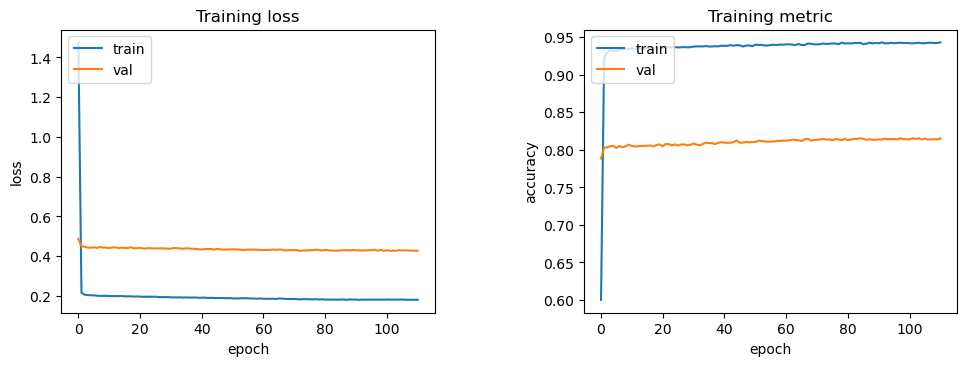

Epoch: 111 - Train Loss: 0.1791 / Validation Loss: 0.4259 / Train acc: 0.9428 / Val acc: 0.8151 / Learning Rate : 0.0000:   0%|          | 111/1000000 [03:46<567:30:19,  2.04s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 86 - Train Loss: 0.1815 / Validation Loss: 0.4194 / Train acc: 0.9395 / Val acc: 0.8220 / Learning Rate : 0.0000:   0%|          | 86/1000000 [06:23<1242:22:45,  4.47s/it]

Training has converged after 86 epochs (lr < 1e-06)


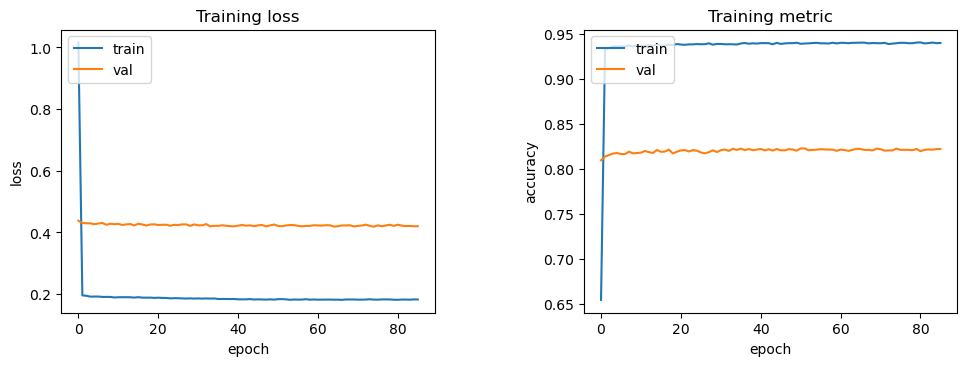

Epoch: 86 - Train Loss: 0.1815 / Validation Loss: 0.4194 / Train acc: 0.9395 / Val acc: 0.8220 / Learning Rate : 0.0000:   0%|          | 86/1000000 [06:23<1237:40:44,  4.46s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 56 - Train Loss: 0.1997 / Validation Loss: 0.4332 / Train acc: 0.9349 / Val acc: 0.8088 / Learning Rate : 0.0000:   0%|          | 56/1000000 [04:09<1236:47:38,  4.45s/it]

Training has converged after 56 epochs (lr < 1e-06)


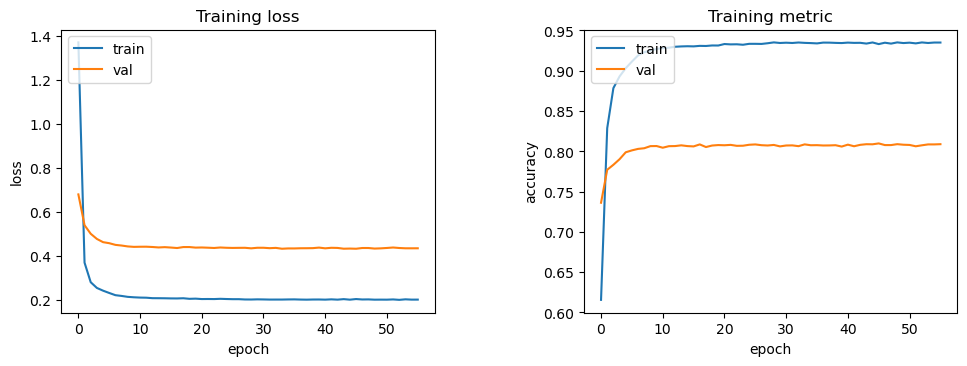

Epoch: 56 - Train Loss: 0.1997 / Validation Loss: 0.4332 / Train acc: 0.9349 / Val acc: 0.8088 / Learning Rate : 0.0000:   0%|          | 56/1000000 [04:09<1238:30:53,  4.46s/it]


Starting retraining for model OT fusion (method 3)


Epoch: 99 - Train Loss: 0.1954 / Validation Loss: 0.4302 / Train acc: 0.9345 / Val acc: 0.8113 / Learning Rate : 0.0000:   0%|          | 99/1000000 [07:20<1234:38:48,  4.45s/it]

Training has converged after 99 epochs (lr < 1e-06)


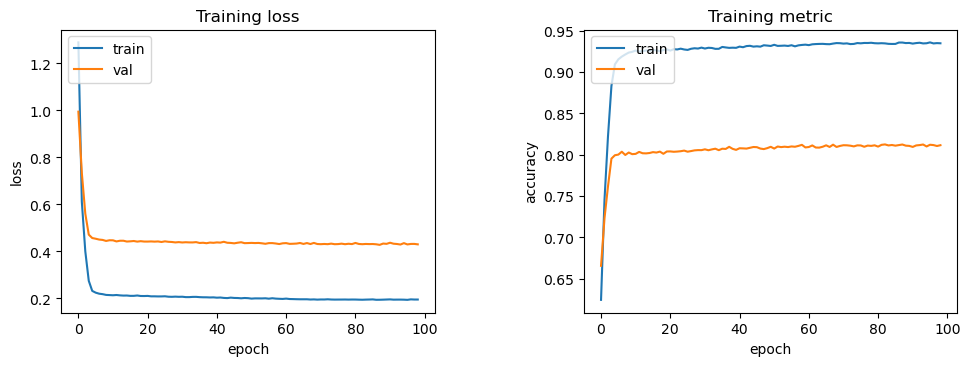

Epoch: 99 - Train Loss: 0.1954 / Validation Loss: 0.4302 / Train acc: 0.9345 / Val acc: 0.8113 / Learning Rate : 0.0000:   0%|          | 99/1000000 [07:21<1237:39:44,  4.46s/it]


OT_post (method 1) loss: 0.42156799882650375 - accuracy: 0.8216104702542117 - f1: 0.8211203217506409
OT_post (method 2) loss: 0.4337842216094335 - accuracy: 0.8071101036025873 - f1: 0.8069047331809998
OT_post (method 3) loss: 0.43251003821690875 - accuracy: 0.810902950135379 - f1: 0.8111355304718018
vanilla_post loss: 0.430374875664711 - accuracy: 0.8137586022111913 - f1: 0.8136740326881409
CPU times: total: 4h 10min 9s
Wall time: 3h 58min 36s


In [11]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i in range(FOLDS):
        print(f'Fold {i + 1}/{FOLDS}')

        # get training, test set
        train_set, test_set = datasets.pop()

        # build generators
        train_iterator, test_iterator, voc_size, pad_idx, embedding = build_generators(train_set, test_set, device, batch_size=512)

        # train parent models
        train_parent = lambda x: train_early_stopping(model_name=x,
                                                      train_iter=train_iterator,
                                                      valid_iter=test_iterator,
                                                      embedding=embedding,
                                                      pad_idx=pad_idx,
                                                      voc_size=voc_size,
                                                      device=device,
                                                      lr=LEARNING_RATE,
                                                      save=False)
        print('Starting training for model A')
        modelA = train_parent('A')
        print('Starting training for model B')
        modelB = train_parent('B')

        # model fusion
        # 1) vanilla
        model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx, voc_size=voc_size, embedding=embedding, device=device)
        # 2) optimal transport
        N_TRIALS = 50
        variations = ['standard', 'multihead', 'cross-multihead']
        # 2.1) method 1
        variation = variations[0]
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, variation=variation), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight (method 1):', best_weighting_factor)
        model_fusion_1 = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=best_weighting_factor, variation=variation)
        # 2.2) method 2
        variation = variations[1]
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, variation=variation), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight (method 2):', best_weighting_factor)
        model_fusion_2 = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=best_weighting_factor, variation=variation)
        # 2.3) method 3
        variation = variations[2]
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, variation=variation), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight (method 3):', best_weighting_factor)
        model_fusion_3 = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=best_weighting_factor, variation=variation)

        # evaluate
        # ensure all models on same device
        model_to_cpu = lambda x: x.to(device)
        modelA = model_to_cpu(modelA)
        modelB = model_to_cpu(modelB)
        model_random = new_model(embedding, pad_idx, voc_size, device, n_head=N_HEADS)
        model_fusion_1 = model_to_cpu(model_fusion_1)
        model_fusion_2 = model_to_cpu(model_fusion_2)
        model_fusion_3 = model_to_cpu(model_fusion_3)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('A', 'B', 'random', 'OT_pre (method 1)', 'OT_pre (method 2)', 'OT_pre (method 3)', 'vanilla_pre'),
                               (modelA, modelB, model_random, model_fusion_1, model_fusion_2, model_fusion_3, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

        # retraining
        retrain = lambda x: train(model=x,
                                  iterator=train_iterator,
                                  valid_iter=test_iterator,
                                  optimizer=torch.optim.SGD(x.parameters(), lr=LEARNING_RATE),
                                  criterion=nn.CrossEntropyLoss(),
                                  epoch=EPOCHS,
                                  clip=1,
                                  device=device)
        # 1) vanilla
        # train with early stopping
        print('Starting retraining for model vanilla fusion')
        retrain(model_fusion_vanilla)

        # 2) optimal transport
        # train with early stopping
        print('Starting retraining for model OT fusion (method 1)')
        retrain(model_fusion_1)
        print('Starting retraining for model OT fusion (method 2)')
        retrain(model_fusion_2)
        print('Starting retraining for model OT fusion (method 3)')
        retrain(model_fusion_3)

        # evaluate
        # ensure all models on same device
        model_fusion_1 = model_to_cpu(model_fusion_1)
        model_fusion_2 = model_to_cpu(model_fusion_2)
        model_fusion_3 = model_to_cpu(model_fusion_3)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('OT_post (method 1)', 'OT_post (method 2)', 'OT_post (method 3)', 'vanilla_post'), (model_fusion_1, model_fusion_2, model_fusion_3, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

### Export as LaTeX

In [ ]:
model_names_latex = ['Model A', 'Model B', 'Vanilla', 'Vanilla (retraining)', 'Optimal transport (method 1)', 'Optimal transport (method 1 - retraining)',
                     'Optimal transport (method 2)', 'Optimal transport (method 2 - retraining)', 'Optimal transport (method 3)', 'Optimal transport (method 3 - retraining)', 'Untrained model (baseline)']

In [ ]:
latex = scores_to_latex(scores, model_names_latex)

In [ ]:
# save as latex (in text format) (optional)
with open('./Output/scores_different_seeds_multihead.txt','w') as dat:
    dat.write(str(latex))